In [20]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import math
import time
import random

# VISUALIZATION
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from pycaret.classification import *
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [21]:
os.chdir(r'/home/grejell/Projects/arab-bank-test-churn-analysis')

X_train = pd.read_pickle('./data/new_X_train.pkl')
Y_train = pd.read_pickle('./data/new_Y_train.pkl')
x_test = pd.read_pickle('./data/new_x_test.pkl')
y_test = pd.read_pickle('./data/new_y_test.pkl')

In [8]:
cleanData = pd.concat([X_train, Y_train], axis=1)


In [11]:
clf1 = setup(cleanData, target = 'target')

best = compare_models(sort='AUC')

best

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Gradient Boosting Classifier,0.7992,0.8419,0.5276,0.6595,0.5850,0.4551,0.4607,1.3349
1,Logistic Regression,0.7998,0.8416,0.5487,0.6544,0.5952,0.4639,0.4681,0.1584
2,Ada Boost Classifier,0.7976,0.8397,0.5437,0.6487,0.5897,0.4573,0.4615,0.4135
3,CatBoost Classifier,0.7900,0.8354,0.5115,0.6374,0.5656,0.4299,0.4355,3.3523
4,Linear Discriminant Analysis,0.7952,0.8331,0.5477,0.6425,0.5900,0.4549,0.4583,0.1740
5,Light Gradient Boosting Machine,0.7852,0.8275,0.5267,0.6187,0.5674,0.4262,0.4296,0.1493
6,Extreme Gradient Boosting,0.7814,0.8254,0.5246,0.6097,0.5622,0.4181,0.4212,1.1967
7,Naive Bayes,0.7058,0.8175,0.8201,0.4741,0.6005,0.3932,0.4306,0.0086
8,Extra Trees Classifier,0.7776,0.7943,0.4885,0.6099,0.5405,0.3967,0.4020,1.2372
9,Random Forest Classifier,0.7746,0.7896,0.4533,0.6106,0.5183,0.3761,0.3841,0.2618


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=6501, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

#### Try to improve the model by tuning the tree-based algorithms

In [12]:
# def split_data(data):
#     data = data.rename(columns={'target': 'labels'})
#     dataX = data.drop(['labels'], axis = 1)
#     dataY = data['labels']
    
#     # Create train and test dataset
#     X_train, x_test, Y_train, y_test = train_test_split(dataX, dataY, random_state = 0)
#     return X_train, x_test, Y_train, y_test

# X_train, x_test, Y_train, y_test = split_data(cleanData)

In [23]:
print(len(X_train))
print(len(x_test))


5274
1758


In [32]:
X_train.shape

(5274, 50)

In [34]:
def bayes_parameter_opt_lgb(X_train, Y_train, init_round=300, n_folds=5, random_seed=23, n_estimators=500, learning_rate=0.01, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X_train, label=Y_train, free_raw_data=False)

    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary', 'learning_rate':0.1, 'metric':'binary_logloss', 'boosting_type':'gbdt'}
        params['num_leaves'] = round(num_leaves).astype(int)
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = round(max_depth).astype(int)
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =0, metrics=['binary_logloss'])
        # print(cv_result)
        return max(cv_result['binary_logloss-mean'])*(-1)

    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (5, 15),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.5, 1),
                                            'max_depth': (50, 100),
                                            'lambda_l1': (0, 3),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 1),
                                            'min_child_weight': (0.001, 1)}, random_state=0)
    
    lgbBO.maximize(init_points=init_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv(".\data\lgbmbayes_opt_result.csv")
   
    # get the best parameters
    optimData = pd.DataFrame(lgbBO.res)
    optim = list(optimData[optimData['target'] == optimData['target'].max()]['params'])
    print('\n')
    print('\n')
    print(optim)
    # return best parameters
    return optim

optim = bayes_parameter_opt_lgb(X_train, Y_train, init_round=300, n_folds=5, random_seed=23, n_estimators=500)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.5561   |  0.7744   |  0.6722   |  1.808    |  1.635    |  71.18    |  0.6462   |  0.4381   |  13.92    |
|  2        | -0.5614   |  0.9818   |  0.4068   |  2.375    |  1.587    |  78.4     |  0.9257   |  0.07197  |  5.871    |
|  3        | -0.5564   |  0.5101   |  0.7661   |  2.334    |  2.61     |  98.93    |  0.7994   |  0.462    |  12.81    |
|  4        | -0.5563   |  0.5591   |  0.6119   |  0.4301   |  2.834    |  76.09    |  0.4152   |  0.2653   |  12.74    |
|  5        | -0.5558   |  0.7281   |  0.5547   |  0.05637  |  1.853    |  80.6     |  0.6173   |  0.9438   |  11.82    |
|  6        | -0.5612   |  0.6798   |  0.4496   |  2.093    |  0.1807   |  83.34    |  0.671    |  0.2112   |  6.289    |
|  7        | -0.5606   

In [35]:
def train_model(X_train, Y_train):
    d_train = lgb.Dataset(X_train, label=Y_train)
    params = {'bagging_fraction': 0.5, 'feature_fraction': 0.9, 'lambda_l1': 0.21694993004324478, 'lambda_l2': 0.0, 'max_depth': round(63.04199235054012), 'min_child_weight': 0.8797172779628719, 'min_split_gain': 0.001, 'num_leaves': round(14.24910382321246)}
    params['learning_rate'] = 0.01
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    lgbmodel = lgb.train(params, d_train, 500, verbose_eval=True)
    return lgbmodel, params

lgbmodel, parameters = train_model(X_train, Y_train)

In [36]:
def predict_data(X, Y, data_type):
    ## predicting test data
    y_pred = lgbmodel.predict(X)
    y_pred_prob = lgbmodel.predict(X)
    for i in range(len(X)):
        if y_pred[i]>=.5: 
           y_pred[i]=1
        else:  
           y_pred[i]=0

    #print accuracy_score(y_test, predicted) for test data
    accuracy = metrics.accuracy_score(y_pred, Y)
    print('\n\n\nThe following are metrices for ', data_type, ' data')
    print('='*50)
    print('='*50)
    preds = pd.DataFrame({'true': Y, 'predicted': y_pred})
    confusion = pd.crosstab(preds['predicted'], preds['true'])
    print('='*50)
    print('\n CONFUSION MATRIX:\n', confusion)
    precision = metrics.precision_score(Y, y_pred)
    print('='*50)
    print('\n', data_type ,'ACCURACY ' + accuracy.astype(str))
    print('\n', data_type ,'PRECISION ' + precision.astype(str))
    recall = metrics.recall_score(Y, y_pred)
    print('\n', data_type ,'RECALL ' + recall.astype(str))
    f1_score = metrics.f1_score(Y, y_pred)
    print('\n', data_type ,'F1 SCORE ' + f1_score.astype(str))
    
    fpr, tpr, thresholds = metrics.roc_curve(Y, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    
    print('\n', data_type ,'AUC ' + auc_score.astype(str))
    print('='*50)
    return y_pred, y_pred_prob, accuracy, precision, recall

y_pred_train,y_pred_prob,_,_,_ = predict_data(X_train, Y_train, data_type='TRAIN')
y_pred_test, y_pred_prob_test, accuracy, precision, recall = predict_data(x_test, y_test, data_type='TEST')




The following are metrices for  TRAIN  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        3527  601
1.0         325  821

 TRAIN ACCURACY 0.8244216913158893

 TRAIN PRECISION 0.7164048865619547

 TRAIN RECALL 0.5773558368495078

 TRAIN F1 SCORE 0.6394080996884736

 TRAIN AUC 0.7464920409585026



The following are metrices for  TEST  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        1192  221
1.0         119  226

 TEST ACCURACY 0.8065984072810012

 TEST PRECISION 0.6550724637681159

 TEST RECALL 0.5055928411633109

 TEST F1 SCORE 0.5707070707070706

 TEST AUC 0.7074112184458813


In [37]:
# traindata_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
# testdata_dmatrix = xgb.DMatrix(data=x_test,label=y_test)

NameError: name 'xgb' is not defined

In [38]:
import xgboost as xgb

In [39]:
def bayes_parameter_opt_xgboost(X_train, Y_train, init_round=100, n_folds=5, random_seed=23, learning_rate=0.01, output_process=False):
    # prepare data
    traindata_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)

    def xgboost_eval(colsample_bytree, subsample, max_depth, gamma, n_estimators, min_child_weight, reg_alpha):
        params = {'objective':'binary:logistic', 'learning_rate':0.01, 'metric':'binary_logloss'}
        params['colsample_bytree'] = max(min(colsample_bytree, 1), 0)
        params['subsample'] = max(min(subsample, 1), 0)
        params['max_depth'] = round(max_depth).astype(int)
        params['gamma'] = max(gamma, 0)
        params['n_estimators'] = int(n_estimators)
        params['min_child_weight'] = round(min_child_weight).astype(int)
        params['reg_alpha'] = reg_alpha
        
        cv_result = xgb.cv(dtrain=traindata_dmatrix, params=params, nfold=5,early_stopping_rounds=100, as_pandas=True, seed=23)

#         print(cv_result)
        return max(cv_result['train-error-mean'])*-1

    xgbBO = BayesianOptimization(xgboost_eval, {
                                            'colsample_bytree': (0.1, 0.9),
                                            'subsample': (0.5, 1),
                                            'max_depth': (5, 10),
                                            'gamma': (0, 1),
                                            'n_estimators':(100,500),
                                            'min_child_weight':(6,20),
                                            'reg_alpha':(1e-5,100)}, random_state=23)
    
    xgbBO.maximize(init_points=init_round)
    
    # output optimization process
    if output_process==True: xgbBO.points_to_csv("./data\/xgb_bayes_opt_result.csv")
   
    # get the best parameters
    optimData = pd.DataFrame(xgbBO.res)
    optim = list(optimData[optimData['target'] == optimData['target'].max()]['params'])
    print('\n')
    print('\n')
    print(optim)
    # return best parameters
    return optim

optim = bayes_parameter_opt_xgboost(X_train, Y_train, init_round=300, n_folds=5, random_seed=23)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | n_esti... | reg_alpha | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        | -0.2184   |  0.5138   |  0.947    |  8.827    |  9.954    |  188.4    |  68.62    |  0.5836   |
|  2        | -0.2503   |  0.414    |  0.6181   |  7.06     |  6.035    |  453.6    |  88.49    |  0.6502   |
|  3        | -0.2121   |  0.5717   |  0.9784   |  9.225    |  6.911    |  217.9    |  28.79    |  0.9112   |
|  4        | -0.2091   |  0.6009   |  0.1105   |  5.003    |  19.19    |  156.6    |  42.16    |  0.6732   |
|  5        | -0.21     |  0.7958   |  0.4286   |  9.144    |  16.05    |  147.7    |  59.64    |  0.5649   |
|  6        | -0.2268   |  0.162    |  0.8312   |  7.322    |  8.268    |  319.2    |  58.85    |  0.8868   |
|  7        | -0.2105   |  0.6247   |  0.5577   |  5.891    |  9.368    |  302.4    |  39.67    |  0.7415   |
|  8      

In [40]:

def train_model(X_train, Y_train):
    data_dmatrix = xgb.DMatrix(data=X_train,label=Y_train)
    params = {'colsample_bytree': 0.8012850280620509, 'gamma': 0.8167888129520258, 'max_depth': round(9.788556017576788), 'min_child_weight': 7.248279349596302, 'n_estimators': 319.9521046057781, 'reg_alpha': 0.904631057920208, 'subsample': 0.7305899319971729,
         'objective':'binary:logistic'}
    model = xgb.train(params=params, dtrain=data_dmatrix)

    return model

xgbmodel = train_model(X_train, Y_train)

In [42]:
def predict_data(x_test, y_test, data_type):
    ## predicting test data
    data_dmatrix = xgb.DMatrix(data=x_test,label=y_test)
    y_pred = xgbmodel = train_model(X_train, Y_train).predict(data_dmatrix)
    y_pred_prob = xgbmodel = train_model(X_train, Y_train).predict(data_dmatrix)
    for i in range(len(x_test)):
        if y_pred[i]>=.5:       # setting threshold to .5
           y_pred[i]=1
        else:  
           y_pred[i]=0

    #print accuracy_score(y_test, predicted) for test data
    accuracy = metrics.accuracy_score(y_pred, y_test)
    print('\n\n\nThe following are metrices for ', data_type, ' data')
    print('='*50)
    preds = pd.DataFrame({'true': y_test, 'predicted': y_pred})
    confusion = pd.crosstab(preds['predicted'], preds['true'])
    print('='*50)
    print('\n CONFUSION MATRIX:\n', confusion)
    precision = metrics.precision_score(y_test, y_pred)
    print('='*50)
    print('\n', data_type ,'ACCURACY ' + accuracy.astype(str))
    print('\n', data_type ,'PRECISION ' + precision.astype(str))
    recall = metrics.recall_score(y_test, y_pred)
    print('\n', data_type ,'RECALL ' + recall.astype(str))
    f1_score = metrics.f1_score(y_test, y_pred)
    print('\n', data_type ,'F1 SCORE ' + f1_score.astype(str))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    
    print('\n', data_type ,'AUC ' + auc_score.astype(str))
    print('='*50)
    return y_pred, y_pred_prob, accuracy, precision, recall

y_pred_train,y_pred_prob,_,_,_ = predict_data(X_train, Y_train, data_type='TRAIN')
y_pred_test, y_pred_prob_test, accuracy, precision, recall = predict_data(x_test, y_test, data_type='TEST')




The following are metrices for  TRAIN  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        3563  539
1.0         289  883

 TRAIN ACCURACY 0.8430034129692833

 TRAIN PRECISION 0.7534129692832765

 TRAIN RECALL 0.6209563994374121

 TRAIN F1 SCORE 0.6808018504240556

 TRAIN AUC 0.7729652194487164



The following are metrices for  TEST  data

 CONFUSION MATRIX:
 true          0    1
predicted           
0.0        1168  218
1.0         143  229

 TEST ACCURACY 0.7946530147895335

 TEST PRECISION 0.6155913978494624

 TEST RECALL 0.5123042505592841

 TEST F1 SCORE 0.5592185592185592

 TEST AUC 0.7016136050660646


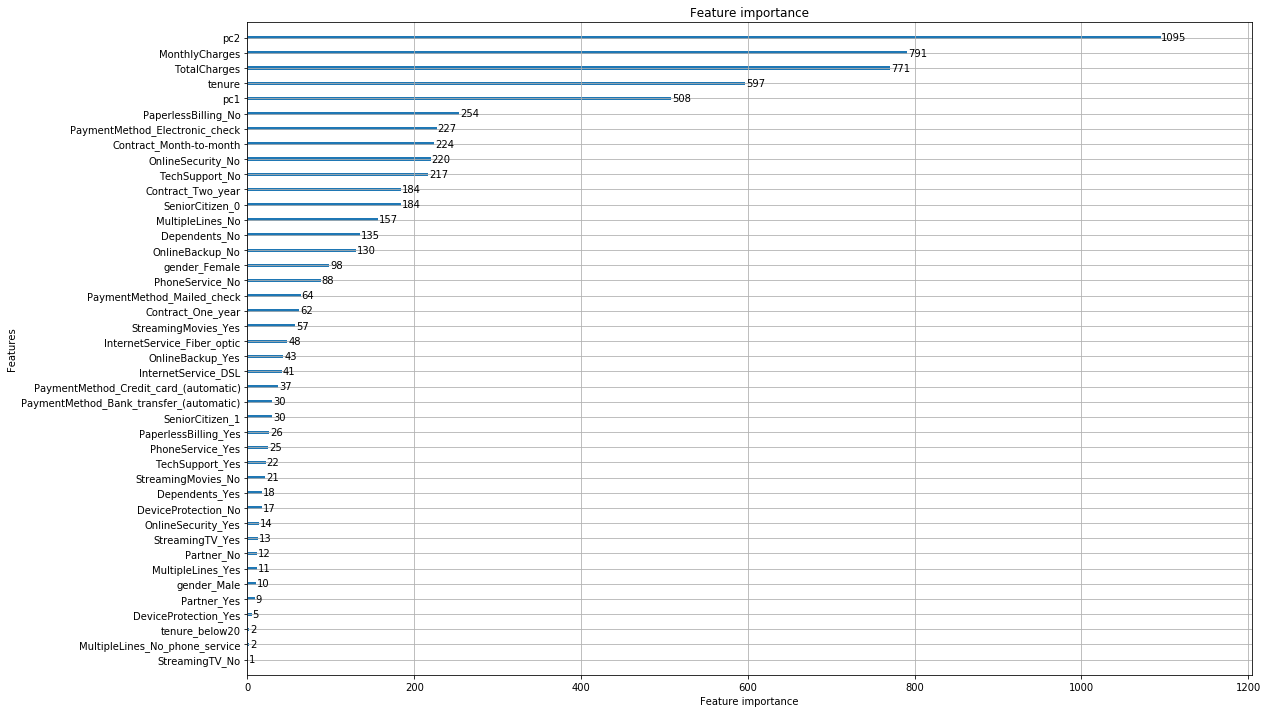

In [44]:
lgb.plot_importance(lgbmodel)
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()

In [46]:
X_train.columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges', 'gender_Female',
       'gender_Male', 'SeniorCitizen_0', 'SeniorCitizen_1', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       '

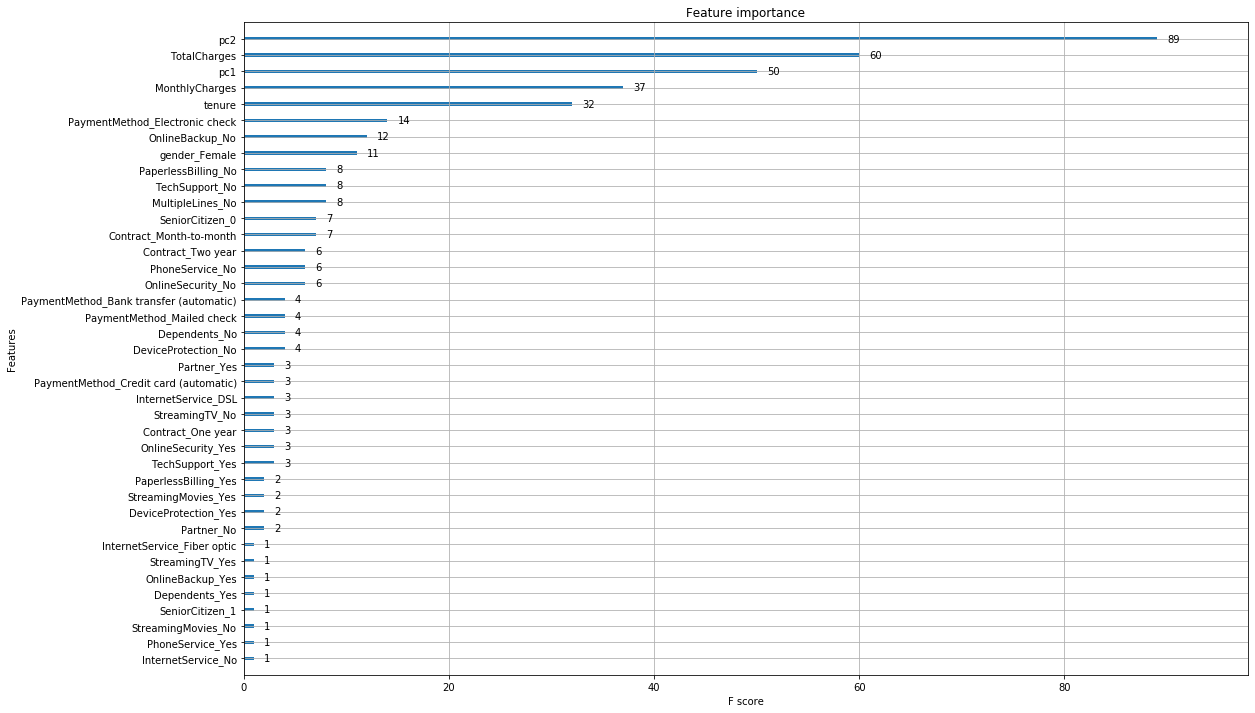

In [45]:
xgb.plot_importance(xgbmodel)
plt.rcParams['figure.figsize'] = [18, 12]
plt.show()